# A k-Armed Bandit Problem

Thin notebook implements various k-armed bandit algorithms.
They are compared using stationary and non-stationary tasks.

## Contents

 * Helper functions
 * Random agent
 * E-Greedy agent
 * Upper-Confidence-Bound agent
 * Gradient agent

# Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4

## Helper functions for bandit generators

Here we create function for creating stationary and non stationiay k-armed bandits.
Non stationary bandids are created using random walk.

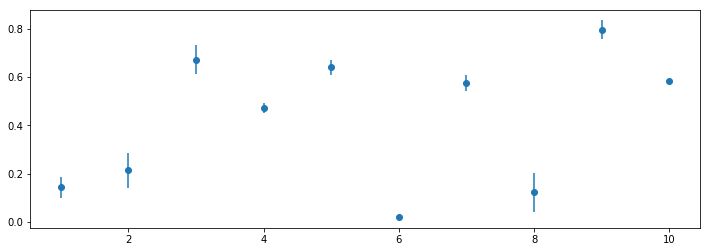

In [3]:
class Bandit:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def roll(self):
        return np.random.normal(self.mean, self.std)
    
    def random_walk(self, step_size=0.1):
        if np.random.rand() > 0.5:
            mean = self.mean+step_size
        else:
            mean = self.mean-step_size
        return Bandit(mean, self.std)


def random_bandits(k, max_mean=1.0, max_std=0.1):
    bs = []
    for _ in range(k):
        mean = np.random.uniform(0.0, max_mean)
        std = np.random.uniform(0.0, max_std)
        bs.append(Bandit(mean, std))
    return bs
    
    
def generate_bandits_list(k, n):    
    """Generate list of n k-armed bandits
       Used to create non stationary process
    """
    bandits = random_bandits(k)
    xs = [bandits]
    for i in range(1, n):
        bs = [b.random_walk() for b in xs[i-1]]
        xs.append(bs)
    return xs

    
def plot_bandits(bs):
    k = len(bs)
    x = np.array(np.linspace(1, k, k))
    y = [x.mean for x in bandits]
    e = [x.std for x in bandits]
    plt.errorbar(x, y, e, linestyle='None', marker='o')
    plt.show()    
    
    
def moving_average(xs, n=100):
    cs = np.cumsum(xs, dtype=float)
    cs[n:] = cs[n:] - cs[:-n]
    return cs[n - 1:] / n    


# Sample bandits
K = 10
bandits = random_bandits(K)
plot_bandits(bandits)

## Helper function for agents and learning

Base class for all agents

In [4]:
class Agent:
    
    def choose_action(self):
        return 0
    
    def learn(self, action, reward):
        pass
    
    
def evaluate_stationary(agent, bandits, num_episodes=1000, window=10):
    """Stationary process. Always use the same bandits"""
    rewards = []
    for episode in range(num_episodes):
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, window)


def evaluate(agent, bandits_list, window=10):
    """Non stationary process. Each episode uses different bandits"""
    rewards = []
    for bandits in bandits_list:
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, window)

# Random agent

This is our first agent
This agent select bandit randomly

In [7]:
class RandomAgent(Agent):
    
    def __init__(self, k):
        self.k = k
        
    def choose_action(self):
        """ Choose which bandit to run. 
        """
        return np.random.choice(range(self.k))
    
    
agent = RandomAgent(K)    
print('Show sample actions selected by this agent')
print([agent.choose_action() for _ in range(20)])

Show sample actions selected by this agent
[8, 1, 4, 7, 3, 1, 0, 4, 6, 7, 9, 1, 7, 4, 1, 0, 3, 3, 7, 5]


#### Lets check the expected reward for this agent

For stationary process the optimal value Q = 0.795650


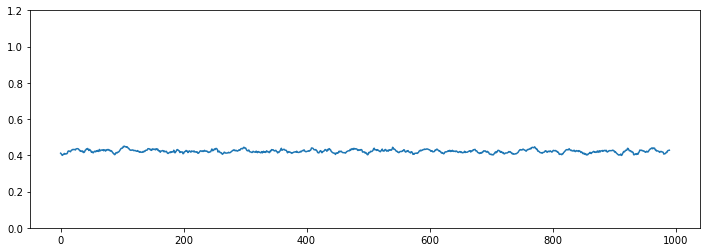

In [12]:
ms = [b.mean for b in bandits]
print('For stationary process the optimal value Q = %f' % np.max(ms))

plt.plot(evaluate_stationary(RandomAgent(K), bandits))
plt.ylim([0, 1.2])
plt.show()

# E-Greedy agent

This agent selects, with high probability, bandit with the highest value function **Q** and with small probability random bandit. 
The value function **Q(a)** is estimated by taking average over all seen rewards when action **a** was selected.

The probability is a trade-off between exploitation and exploration.

In [13]:
class EGreedyAgent(Agent):
    
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k)
        self.counters = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        n = self.counters[action]
        self.Q[action] = (self.Q[action]*n + reward)/(n+1)
        self.counters[action] += 1

## Lets evalaute this agent

Here we evaluate agent with different epsilon values.

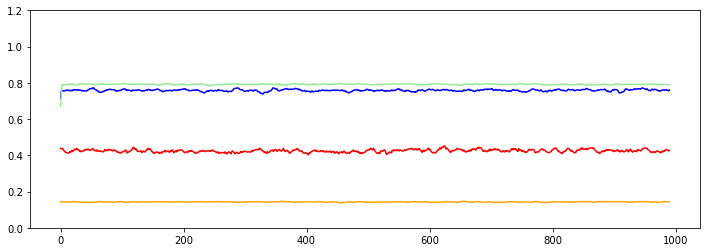

In [15]:
plt.plot(evaluate_stationary(RandomAgent(K), bandits), color='red')
plt.plot(evaluate_stationary(EGreedyAgent(K, 0.0), bandits), color='orange')
plt.plot(evaluate_stationary(EGreedyAgent(K, 0.1), bandits), color='blue')
plt.plot(evaluate_stationary(EGreedyAgent(K, 0.01), bandits), color='lightgreen')
plt.ylim([0, 1.2])
plt.show()

For the stationary series in the long term it is best to use agent with low epsilon value

## Learning rate

EGreedyAgent keeps average reward and counter for each action to update value function **Q**.

To make it more efficient we can change the update rule:

$$ Q'_{a} = \frac{Q_{a}*(n-1) + r}{n} = Q - \frac{Q_{a}}{n} + \frac{r}{n} = Q + \frac{1}{n}(r-Q_{a}) $$


where:
  * $Q_{a}$ - Value function
  * a - action
  * r - current reward
  * n - counter (how many times this action was selected)
  * $r-Q$  - Error term
  * $\alpha = \frac{1}{n}$ - Learning rate
  
 So the final update rule is:
 
 $$ Q_{a}' = Q_{a} + \alpha(r-Q_{a}) $$

In [16]:
class AlphaAgent:
    
    def __init__(self, k, epsilon, alpha=0.1):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        self.Q[action] = self.Q[action] + self.alpha*(reward-self.Q[action])


## Lets compare agents

Now lets compare e-greedy agent with alpha agent

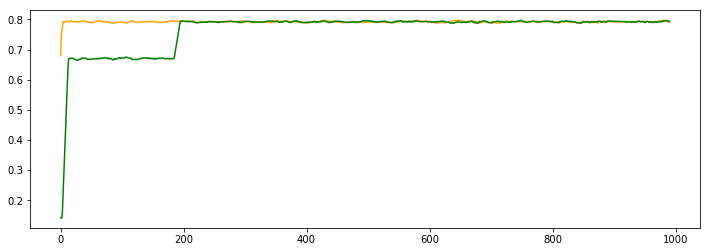

In [18]:
plt.plot(evaluate_stationary(EGreedyAgent(K, 0.01), bandits), color='orange')
plt.plot(evaluate_stationary(AlphaAgent(K, 0.01), bandits), color='green')
plt.show()

For stationary environment our new agents takes a little bit longer to learn but still achive the same score.

Lets compare agents for not stationary environment


## Non stationary bandits

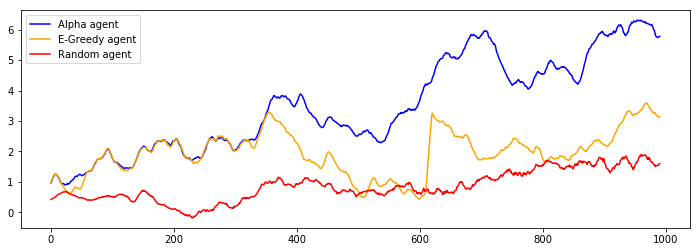

In [28]:
bandits_list = generate_bandits_list(K, 1000)
plt.plot(evaluate(AlphaAgent(K, 0.1), bandits_list), color='blue', label='Alpha agent')
plt.plot(evaluate(EGreedyAgent(K, 0.1), bandits_list), color='orange', label='E-Greedy agent')
plt.plot(evaluate(RandomAgent(K), bandits_list), color='red', label='Random agent')
plt.legend()
plt.show()

In the long term AlphaAgent learns faster since it doesn't average over all seen rolls.

But it highly depend on the underlining process.

# Upper-Confidence-Bound Action Selection

The e-greedy agent explore with probabilities which doesn't depend on the value function.
The UCB tries to estimate the value function and variance for each action. 
Then action is selected based on both value and variance.

The formula to select action:

$$ A_t = argmax_{a} \left[ Q_t(a) + c \sqrt{ \frac{log(t)}{N_t(a)} } \right] $$

Where:
  * $\sqrt{ \frac{log(t)}{N_t(a)} }$ - Is variance (uncertainty) of action value
  * $N_t(a)$ - How many times this action was selected
  * c - controls the degree of exploration

In [29]:
class UCBAgent(Agent):
    
    def __init__(self, k, c=2.0):
        self.k = k
        self.c = c
        self.Q = np.zeros(k)
        self.counters = np.zeros(k)
        
    def choose_action(self):
        if np.min(self.counters) == 0:
            return np.argmin(self.counters)
        else:
            t = np.sum(self.counters)
            var = self.c * np.sqrt(np.log(t)/self.counters)
            return np.argmax(self.Q + var)
        
    def learn(self, action, reward):
        n = self.counters[action]
        self.Q[action] = (self.Q[action]*n + reward)/(n+1)
        self.counters[action] += 1

## Compare agent

Stationary series

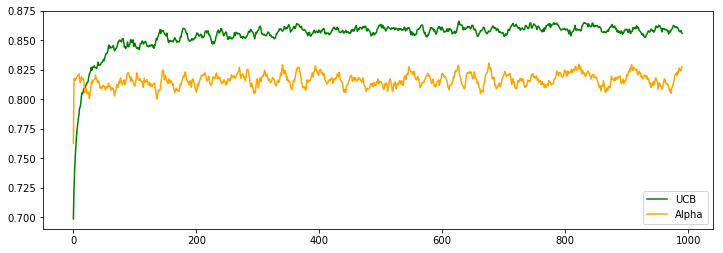

In [44]:
plt.plot(evaluate_stationary(UCBAgent(K), bandits), color='green', label='UCB')
plt.plot(evaluate_stationary(AlphaAgent(K, 0.1), bandits), color='orange', label='Alpha')
plt.legend()
plt.show()

UCB is better for non statinary since in the long run the confidence intervals are getting smaller.

But lest check **non-stationary** bandits

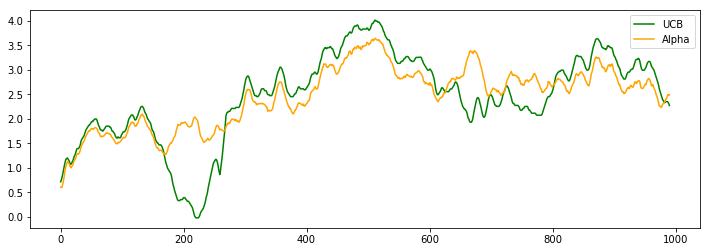

In [42]:
bandits_list = generate_bandits_list(K, 1000)
plt.plot(evaluate(UCBAgent(K), bandits_list), color='green', label='UCB')
plt.plot(evaluate(AlphaAgent(K, 0.1), bandits_list), color='orange', label='Alpha')
plt.legend()
plt.show()

# GradientAgent

This agent uses preference function $H_{t}(a)$ for selecting action. The preference function is not probability distribution. To convert it to probability distribution we will use **softmax** function.

$$ Pr\{A_{t}=a\} = \frac{e^{H_{t}(a)}}{\sum\limits_{b=1}^{k} e^{H_{t}(b)}} = \pi_{t}(a)$$

The absolute value of the preference function doesn't matter. What is important is relative preferences (Thanks to the softmax). So if we add 100 for each action we will end up with the same probabilities as before addition.

In [45]:
class GradientAgent(Agent):
    
    def __init__(self, k=10, epsilon=0.1, alpha=0.1):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.H = np.zeros(k)
        self.Q = np.zeros(k)
        
    def choose_action(self):
        return np.random.choice(self.k, 1, p=self.softmax())[0]
        
    def learn(self, action, reward):
        self.Q[action] = self.Q[action] + 0.1*(reward-self.Q[action])
        pi = self.softmax()
        for i in range(self.k):
            if i == action:
                self.H[i] = self.H[i] + self.alpha*(reward-self.Q[i])*(1.0-pi[i])
            else:
                self.H[i] = self.H[i] - self.alpha*(reward-self.Q[i])*pi[i]
        
    def softmax(self):
        "Return list of probabilities"
        H_exp = np.exp(self.H)
        return H_exp / np.sum(H_exp)

## Compare Agents

Compare GreedyAgent with GradientAgent using stationary process.

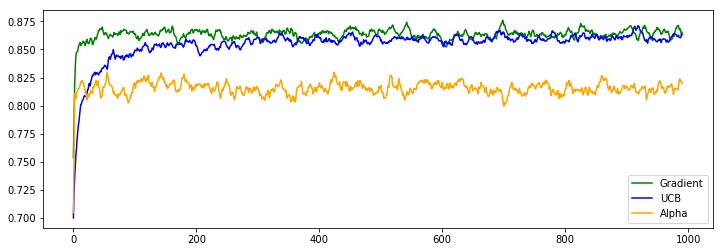

In [52]:
plt.plot(evaluate_stationary(GradientAgent(K, alpha=0.1), bandits), color='green', label='Gradient')
plt.plot(evaluate_stationary(UCBAgent(K), bandits), color='blue', label='UCB')
plt.plot(evaluate_stationary(AlphaAgent(K, epsilon=0.1), bandits), color='orange', label='Alpha')
plt.legend()
plt.show()

And for **non-stationary**

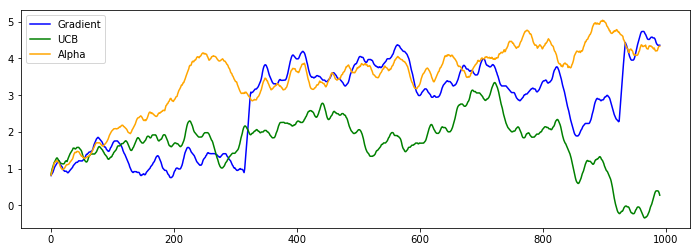

In [56]:
bandits_list = generate_bandits_list(K, 1000)
plt.plot(evaluate(GradientAgent(K, alpha=0.1), bandits_list), color='blue', label='Gradient')
plt.plot(evaluate(UCBAgent(K), bandits_list), color='green', label='UCB')
plt.plot(evaluate(AlphaAgent(K, 0.1), bandits_list), color='orange', label='Alpha')
plt.legend()
plt.show()